In [2]:
%matplotlib inline
import matplotlib.transforms
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta

In [5]:
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

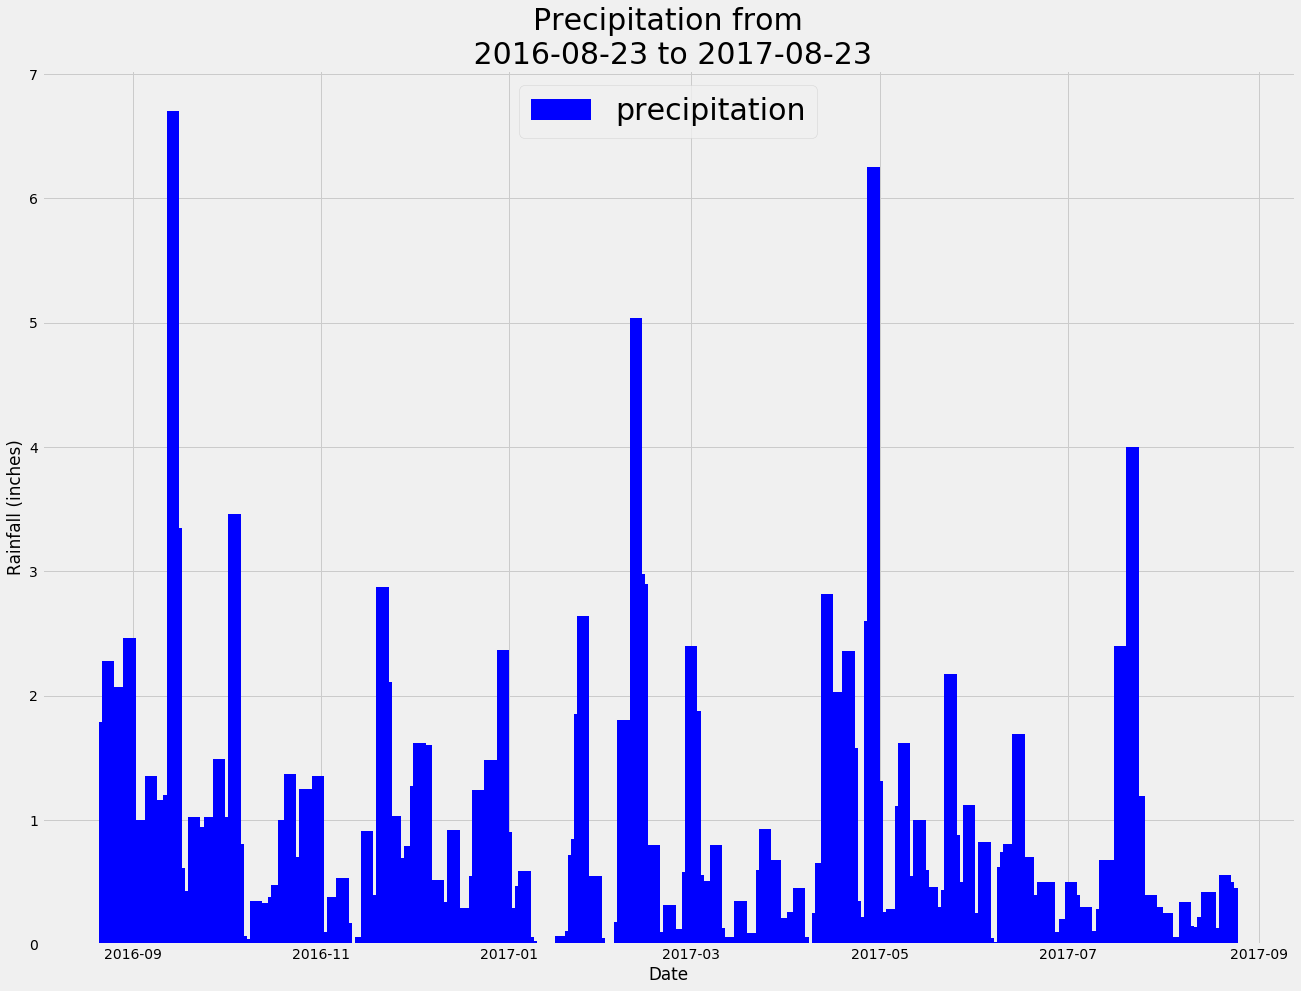

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Get the most recent date from the dataset
last_date_in_dataset = engine.execute('SELECT max(date) FROM measurement').fetchall()[0][0]

#convert this to an actual date so date math can be performed
last_date_in_dataset = dt.datetime.strptime(last_date_in_dataset,'%Y-%m-%d')

# Subtract a year from this date
start_date = last_date_in_dataset - relativedelta(years=1)

# create a result set that is grouped by date for the last 12 months of data contained in the full dataset
results = session.query(Measurement.date, Measurement.prcp, Measurement.station, Measurement.tobs).all()

# put this result set into a dataframe
results_df = pd.DataFrame(results, columns=['date', 'prcp', 'station', 'tobs'])

# change the date datatype to a date - rename the prcp column
results_df['date'] =  pd.to_datetime(results_df['date'], format='%Y-%m-%d')
results_df = results_df.rename(columns={'prcp': 'precipitation'})

# build a 12 month DF based on the comupted startdate from above
last_year_meas_df = pd.DataFrame(results_df.loc[results_df['date'] >= start_date, :])

# set the index to the date and sort by the index
last_year_meas_df.set_index('date', inplace=True, )
last_year_meas_df.sort_index(inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data
# enlarge the figure and fonts to make it easier to see

#define some variable to be used to set the font sizes
largefont = 30
mediumfont = 22
smallfont = 10

# set the figsize and set the font sizes to look nice with this figure size
fig, ax = plt.subplots(figsize=(20, 15))
plt.rc('axes', titlesize=largefont)     # fontsize of the axes title
plt.rc('axes', labelsize=largefont)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=mediumfont)    # fontsize of the tick labels
plt.rc('ytick', labelsize=mediumfont)    # fontsize of the tick labels
plt.rc('legend', fontsize=largefont)    # legend fontsize
plt.rc('figure', titlesize=largefont)  # fontsize of the figure title

# Create the bar chart
plt.bar(last_year_meas_df.index, last_year_meas_df.precipitation, width=4, color='b', label='precipitation')

# Add title, legend and axis labels
plt.title("Precipitation from\n " + dt.datetime.strftime(start_date,'%Y-%m-%d')\
          + " to " + dt.datetime.strftime(last_date_in_dataset,'%Y-%m-%d'))
plt.legend(loc='upper center')
plt.xlabel("Date")
plt.ylabel("Rainfall (inches)")


plt.savefig("Images/Precipitation from " + dt.datetime.strftime(start_date,'%Y-%m-%d')\
          + " to " + dt.datetime.strftime(last_date_in_dataset,'%Y-%m-%d') + ".png", bbox_inches='tight')

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_summary = last_year_meas_df['precipitation'].describe()
prcp_summary

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
station_count = results_df["station"].value_counts()
len(station_count)

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

print(station_count)

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
max_station = station_count[station_count == station_count.max()].index[0]
max_station_data = results_df[results_df['station']==max_station]

max_station_summary = [(max_station_data['tobs'].min(), max_station_data['tobs'].max(), max_station_data['tobs'].mean() )]
print(max_station_summary)

[(54.0, 85.0, 71.66378066378067)]


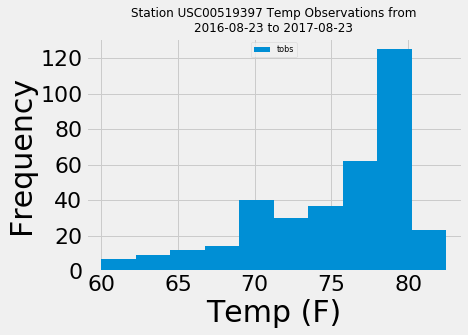

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# I could use the station with the highest number of temperature observations from the data set but 
# I beleive the analysis is better if I use the data from the station with the highest observations within the period
# of the analysis.  It could be the station with the highest in the data set has stopped working during the 
# Time period of the analysis.  Therefore I Recalculate the max_station

ly_station_count = last_year_meas_df["station"].value_counts()
max_station = ly_station_count[ly_station_count == ly_station_count.max()].index[0]
last_year_max_station_data = last_year_meas_df[last_year_meas_df['station']==max_station]

# This chart is a smaller chart so I change the font sizes to match the chart size
largefont = 16
mediumfont = 12
smallfont = 8

# Create the histogram chart and set the font sizes
last_year_max_station_data.hist(column='tobs', bins=12, label = 'tobs')

plt.rc('axes', titlesize=mediumfont)     # fontsize of the axes title
plt.rc('axes', labelsize=mediumfont)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=mediumfont)    # fontsize of the tick labels
plt.rc('ytick', labelsize=mediumfont)    # fontsize of the tick labels
plt.rc('legend', fontsize=smallfont)    # legend fontsize
plt.rc('figure', titlesize=largefont)  # fontsize of the figure title

# Add title, legend and axis labels and change the limits to make the chart look good
plt.title("Station " + max_station + " Temp Observations from\n" + dt.datetime.strftime(start_date,'%Y-%m-%d')\
          + " to " + dt.datetime.strftime(last_date_in_dataset,'%Y-%m-%d'))
plt.legend(loc='upper center')
plt.xlabel("Temp (F)")
plt.ylabel("Frequency")
plt.xlim(59,83.5)


plt.savefig("Images/Station_" + max_station + "_tobs_bins.png", bbox_inches='tight')

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


start_date = dt.date(2017, 2, 28)
end_date = dt.date(2017, 3, 5)
tripstart = dt.datetime.strftime(start_date,'%Y-%m-%d')
tripend = dt.datetime.strftime(end_date,'%Y-%m-%d')

year_calc = calc_temps(tripstart, tripend)

print(year_calc)


[(64.0, 72.02777777777777, 78.0)]


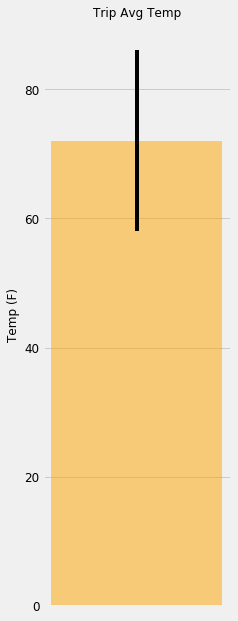

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = np.arange(len(year_calc))
trip_mean = [year_calc[0][1]]
error = [(year_calc[0][2] - year_calc[0][0]) ]


fig, ax = plt.subplots(figsize=(3, 10))
ax.bar(x_pos, trip_mean, yerr=error, align='center', alpha=0.5, color='orange')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
ax.xaxis.grid(False)

# This yerr is 29 degrees which makes the chart look odd.  There was likely some weather event...like we just had
# that is causing the dramatic delta between the two days that are one year apart.

plt.savefig("Images/Trip Avg Temp between " + tripstart + " and " + tripend + ".png", bbox_inches='tight')

In [21]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


# Crate a df with the station data
station_data = session.query(Station.id, Station.elevation, Station.latitude, Station.longitude, Station.station,\
                            Station.name).all()

station_data_df = pd.DataFrame(station_data, columns=['id', 'elevation', 'latitude', 'longitude', 'station', 'name'])

# get rid of the id column and set the index to station to make joining the the station info with precipitation data easy
station_data_df.drop(['id'], axis=1, inplace=True)
station_data_df.set_index('station', inplace=True)

# create a group by using the last year data frame
last_year_station_group_by = last_year_meas_df.groupby(['station'])

# build a sum on 
station_precip = last_year_station_group_by['precipitation'].sum()

# join the data sets and sort them by precipitation in descending order
station_w_precip = station_data_df.join(station_precip, how='inner')
station_w_precip.sort_values(by=['precipitation'], ascending=False)

# drop the index, reorder the columns and convert to a tuple for output processing 
station_w_precip.reset_index(inplace=True)

station_w_precip = station_w_precip[ ['station', 'name', 'elevation', 'latitude', 'longitude', 'precipitation']]
station_w_precip_t = [tuple(x) for x in station_w_precip.values]

print(station_w_precip_t)


[('USC00519397', 'WAIKIKI 717.2, HI US', 3.0, 21.2716, -157.8168, 16.089999999999986), ('USC00513117', 'KANEOHE 838.1, HI US', 14.6, 21.4234, -157.8015, 48.510000000000026), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 7.0, 21.5213, -157.8374, 33.239999999999995), ('USC00517948', 'PEARL CITY, HI US', 11.9, 21.3934, -157.9751, 4.59), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 19.5, 21.33556, -157.71139, 38.01), ('USC00519281', 'WAIHEE 837.5, HI US', 32.9, 21.45167, -157.84888999999998, 70.03000000000003), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 152.4, 21.3331, -157.8025, 147.81000000000006)]


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
print(daily_normals("01-01"))

[(62.0, 69.15384615384616, 77.0)]


In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
date_list = []
mins = []
maxs = []
avgs = []


# Use the tripstart and tripend dates to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
def generate_dates(start_date, end_date):
    td = dt.timedelta(hours=24)
    current_date = start_date
    while current_date <= end_date:
        date_list.append(dt.datetime.strftime(current_date,'%Y-%m-%d'))
        t = daily_normals(dt.datetime.strftime(current_date,'%m-%d'))
        normals.append(t)
        mins.append(t[0][0])
        maxs.append(t[0][2])
        avgs.append(t[0][1])
        current_date += td

generate_dates(start_date, end_date)


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
date_summaries = pd.DataFrame()
date_summaries['date'] = date_list
date_summaries['min'] = mins
date_summaries['max'] = maxs
date_summaries['avg'] = avgs

date_summaries

,date,min,max,avg
0,2017-02-28,65.0,80.0,70.655172
1,2017-03-01,64.0,76.0,70.032787
2,2017-03-02,61.0,78.0,70.366667
3,2017-03-03,60.0,78.0,70.068966
4,2017-03-04,57.0,77.0,69.272727
5,2017-03-05,60.0,76.0,67.890909


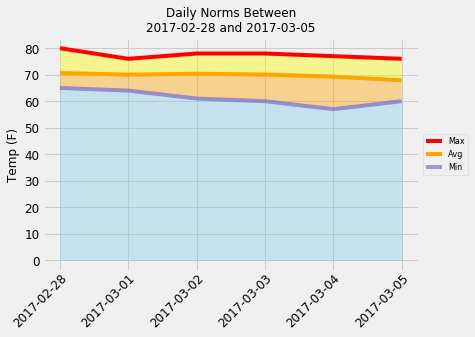

In [32]:
# Plot the daily normals as an area plot with `stacked=False`

fig, ax = plt.subplots()
plt.fill_between(date_list, avgs, maxs, where=maxs >= avgs, facecolor='yellow', alpha=0.4)
plt.plot(date_list, maxs, color="red", label = 'Max')
plt.fill_between(date_list, mins, avgs, where=avgs >= mins, facecolor='orange', alpha=0.4)
plt.plot(date_list, avgs, color="Orange", label = 'Avg')
plt.fill_between( date_list, mins, color="skyblue", alpha=0.4)
plt.plot(date_list, mins, color="Slateblue", alpha=0.6, label = 'Min')


plt.setp( ax.xaxis.get_majorticklabels(), rotation=45) 

# Create offset transform by -20 points in x direction and 3 points in the y direction
dx = -20/72.; dy = 3/72. 
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
# add a legend outside of the chart
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# add a title
plt.title('Daily Norms Between\n' + tripstart + ' and ' + tripend)
          

# add the x and y labels
plt.ylabel('Temp (F)')


plt.savefig("Images/Daily_Norms_Between_" + tripstart + "_and_" + tripend + ".png", bbox_inches='tight')